# Feature Engineering - Morocco Airbnb Pricing Model

**Dataset**: `morocco_listings_full.csv` (65,988 listings)

**Objective**: Create optimized features for price prediction based on EDA insights

## 🎯 Feature Engineering Strategy

Based on EDA findings:

### Key Insights from EDA:
1. **Strong correlations**: total_price (0.69), bedroom_count (0.16), bed_count (0.13)
2. **Geographic variation**: 61% price difference across cities
3. **Seasonal patterns**: 28.3% variation (winter highest, summer lowest)
4. **Superhost premium**: 5.4% higher prices
5. **Stay length**: Negative correlation (-0.40) - longer stays = lower nightly rate

### Feature Categories:

**1. Remove Data Leakage** (Critical)
- ❌ `total_price` - Direct derivative of target
- ❌ `check_in`, `check_out` - Temporal leakage

**2. Base Numeric Features** (Keep)
- ✅ `stay_length_nights` - Strong predictor
- ✅ `bedroom_count`, `bed_count` - Property size indicators
- ✅ `discount_rate` - Pricing strategy
- ✅ `rating_value`, `rating_count` - Quality signals
- ✅ `latitude`, `longitude` - Geographic coordinates

**3. Categorical Features** (Encode)
- ✅ `city` - 61% price variation
- ✅ `season` - 28% price variation
- ✅ `room_type` - Entire home vs Private room
- ✅ `property_type` - Apartment, House, etc.

**4. Engineered Features** (Create)
- 🆕 `beds_per_bedroom` - Occupancy density
- 🆕 `city_tier` - Price-based city grouping
- 🆕 `is_peak_season` - Winter (highest prices)
- 🆕 `is_long_stay` - 14+ nights
- 🆕 `has_high_rating` - rating ≥ 4.5
- 🆕 `luxury_indicator` - High-end properties

**Target**: `nightly_price` (Mean: 599 MAD, Median: 467 MAD)

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Paths
ROOT = Path('/home/medgm/vsc/dApp-Ai')
DATA_PATH = ROOT / 'data' / 'morocco_listings_full.csv'
OUTPUT_PATH = ROOT / 'data' / 'used_or_will_be_used' / 'morocco_listings_engineered.csv'

print("🔧 Feature Engineering Pipeline")
print("=" * 70)

🔧 Feature Engineering Pipeline


In [2]:
# Load raw data
df_raw = pd.read_csv(DATA_PATH)

print(f"✓ Loaded raw dataset: {len(df_raw):,} listings")
print(f"✓ Original features: {len(df_raw.columns)} columns")
print(f"\nDataset shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

df_raw.head(3)

✓ Loaded raw dataset: 65,988 listings
✓ Original features: 26 columns

Dataset shape: (65988, 26)
Memory usage: 57.24 MB


,room_id,listing_name,title,city_slug,city,latitude,longitude,season,check_in,stay_length_nights,check_out,total_price,currency,nightly_price,discount_rate,bedroom_count,bed_count,room_type,property_type,rating_value,rating_count,badge_count,badges,is_superhost,image_count,file_source
0,657018419326569906,"Lovely, Calm Apartment with Sea View",Apartment in Al Hoceima,al_hociema,Al Hoceima,35.2372,-3.9573,winter,2026-02-01,7,2026-02-08,2893.0000,MAD,413.2900,0.8071,1,2,Entire home/apt,Apartment,4.9300,116,1,GUEST_FAVORITE,False,6,data/raw_scrapes_expanded/by_city/al_hociema/a...
1,1528297098782379139,Apartment with full sea view,Apartment in Al Hoceima,al_hociema,Al Hoceima,35.2287,-3.9228,winter,2026-02-01,7,2026-02-08,3156.0000,MAD,450.8600,0.9113,2,3,Entire home/apt,Apartment,0.0000,0,1,SUPERHOST,True,6,data/raw_scrapes_expanded/by_city/al_hociema/a...
2,1403878872257533765,Welcome to THE VIEW!,Apartment in Al Hoceima,al_hociema,Al Hoceima,35.2428,-3.9499,winter,2026-02-01,7,2026-02-08,6391.0000,MAD,913.0000,0.0000,3,7,Entire home/apt,Apartment,5.0000,16,1,GUEST_FAVORITE,False,6,data/raw_scrapes_expanded/by_city/al_hociema/a...


## 2. Remove Data Leakage Features

In [3]:
# Features to remove (data leakage)
leakage_features = [
    'total_price',      # Direct derivative of nightly_price × stay_length
    'check_in',         # Temporal leakage - specific dates
    'check_out',        # Temporal leakage - specific dates
    'listing_name',     # Too specific, high cardinality
    'title',            # Information already in room_type/property_type
    'room_id',          # Identifier, not predictive
    'city_slug',        # Redundant with 'city'
    'currency',         # All MAD, no variation
    'badges',           # High missing rate (38.8%), info in badge_count
    'file_source'       # Data lineage, not predictive
]

print("🚫 Removing Data Leakage Features:")
print("=" * 70)
for feat in leakage_features:
    if feat in df_raw.columns:
        print(f"   ❌ {feat}")
        
df = df_raw.drop(columns=[f for f in leakage_features if f in df_raw.columns])

print(f"\n✓ Reduced from {len(df_raw.columns)} to {len(df.columns)} features")
print(f"\nRemaining columns: {df.columns.tolist()}")

🚫 Removing Data Leakage Features:
   ❌ total_price
   ❌ check_in
   ❌ check_out
   ❌ listing_name
   ❌ title
   ❌ room_id
   ❌ city_slug
   ❌ currency
   ❌ badges
   ❌ file_source

✓ Reduced from 26 to 16 features

Remaining columns: ['city', 'latitude', 'longitude', 'season', 'stay_length_nights', 'nightly_price', 'discount_rate', 'bedroom_count', 'bed_count', 'room_type', 'property_type', 'rating_value', 'rating_count', 'badge_count', 'is_superhost', 'image_count']


## 3. Create Engineered Features

In [4]:
print("\n🆕 Creating Engineered Features")
print("=" * 70)

# 1. Beds per bedroom ratio (occupancy density)
df['beds_per_bedroom'] = np.where(
    df['bedroom_count'] > 0,
    df['bed_count'] / df['bedroom_count'],
    df['bed_count']  # For studios (0 bedrooms)
)
print("✓ beds_per_bedroom - Occupancy density ratio")
print(f"  Range: {df['beds_per_bedroom'].min():.2f} - {df['beds_per_bedroom'].max():.2f}")
print(f"  Mean: {df['beds_per_bedroom'].mean():.2f}")

# 2. City tier (based on EDA price analysis)
# Tier 1: Premium cities (Marrakech, Rabat, Agadir, Tangier)
# Tier 2: Mid-range cities (Ouarzazate, Casablanca, Fes, Meknes, Al Hoceima)
# Tier 3: Budget cities (Essaouira, Tétouan, Chefchaouen, Oujda)
city_tier_map = {
    'Marrakech': 1, 'Rabat': 1, 'Agadir': 1, 'Tangier': 1,
    'Ouarzazate': 2, 'Casablanca': 2, 'Fes': 2, 'Meknes': 2, 'Al Hoceima': 2,
    'Essaouira': 3, 'Tétouan': 3, 'Chefchaouen': 3, 'Oujda': 3
}
df['city_tier'] = df['city'].map(city_tier_map)
print("\n✓ city_tier - Price-based city grouping (1=Premium, 2=Mid, 3=Budget)")
print(f"  Distribution: {df['city_tier'].value_counts().sort_index().to_dict()}")

# 3. Peak season indicator (Winter = highest prices from EDA)
df['is_peak_season'] = (df['season'] == 'winter').astype(int)
print("\n✓ is_peak_season - Winter season indicator")
print(f"  Peak season listings: {df['is_peak_season'].sum():,} ({df['is_peak_season'].mean()*100:.1f}%)")

# 4. Long stay indicator (14+ nights gets better rates)
df['is_long_stay'] = (df['stay_length_nights'] >= 14).astype(int)
print("\n✓ is_long_stay - 14+ nights indicator")
print(f"  Long stays: {df['is_long_stay'].sum():,} ({df['is_long_stay'].mean()*100:.1f}%)")

# 5. High rating indicator (rating ≥ 4.5)
df['has_high_rating'] = (df['rating_value'] >= 4.5).astype(int)
print("\n✓ has_high_rating - Rating ≥ 4.5 indicator")
print(f"  High-rated properties: {df['has_high_rating'].sum():,} ({df['has_high_rating'].mean()*100:.1f}%)")

# 6. Luxury indicator (3+ bedrooms OR Villa/Boutique hotel)
df['is_luxury'] = ((df['bedroom_count'] >= 3) | 
                   (df['property_type'].isin(['Villa', 'Boutique hotel']))).astype(int)
print("\n✓ is_luxury - 3+ bedrooms or premium property type")
print(f"  Luxury properties: {df['is_luxury'].sum():,} ({df['is_luxury'].mean()*100:.1f}%)")

# 7. Property size category (based on bedrooms)
df['size_category'] = pd.cut(
    df['bedroom_count'],
    bins=[-1, 0, 1, 2, 100],
    labels=['Studio', 'Small', 'Medium', 'Large']
)
print("\n✓ size_category - Property size based on bedrooms")
print(f"  Distribution:\n{df['size_category'].value_counts().sort_index()}")

# 8. Total capacity (bedrooms + beds)
df['total_capacity'] = df['bedroom_count'] + df['bed_count']
print("\n✓ total_capacity - Combined bedroom + bed count")
print(f"  Range: {df['total_capacity'].min():.0f} - {df['total_capacity'].max():.0f}")
print(f"  Mean: {df['total_capacity'].mean():.2f}")


🆕 Creating Engineered Features
✓ beds_per_bedroom - Occupancy density ratio
  Range: 0.00 - 34.00
  Mean: 1.27

✓ city_tier - Price-based city grouping (1=Premium, 2=Mid, 3=Budget)
  Distribution: {1: 21376, 2: 23977, 3: 20635}

✓ is_peak_season - Winter season indicator
  Peak season listings: 15,256 (23.1%)

✓ is_long_stay - 14+ nights indicator
  Long stays: 14,361 (21.8%)

✓ has_high_rating - Rating ≥ 4.5 indicator
  High-rated properties: 48,341 (73.3%)

✓ is_luxury - 3+ bedrooms or premium property type
  Luxury properties: 9,706 (14.7%)

✓ size_category - Property size based on bedrooms
  Distribution:
size_category
Studio     6759
Small     22534
Medium    27197
Large      9498
Name: count, dtype: int64

✓ total_capacity - Combined bedroom + bed count
  Range: 0 - 90
  Mean: 4.08


## 4. Encode Categorical Features

In [5]:
print("\n🔢 Encoding Categorical Features")
print("=" * 70)

# One-hot encode categorical features
categorical_features = ['city', 'season', 'room_type', 'property_type', 'size_category']

print("\nCategorical features to encode:")
for feat in categorical_features:
    unique_count = df[feat].nunique()
    print(f"  • {feat:20s}: {unique_count:2d} unique values")

# Create dummy variables
df_encoded = pd.get_dummies(
    df,
    columns=categorical_features,
    prefix=categorical_features,
    drop_first=True  # Avoid multicollinearity
)

print(f"\n✓ After one-hot encoding: {len(df_encoded.columns)} features")
print(f"  Added {len(df_encoded.columns) - len(df.columns)} dummy variables")


🔢 Encoding Categorical Features

Categorical features to encode:
  • city                : 13 unique values
  • season              :  4 unique values
  • room_type           :  2 unique values
  • property_type       :  8 unique values
  • size_category       :  4 unique values

✓ After one-hot encoding: 45 features
  Added 21 dummy variables


In [6]:
# Display feature summary
print("\n📊 Final Feature Summary")
print("=" * 70)

print("\n1. NUMERIC FEATURES:")
numeric_features = df_encoded.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('nightly_price')  # Exclude target
for i, feat in enumerate(numeric_features, 1):
    print(f"   {i:2d}. {feat}")

print(f"\n   Total numeric features: {len(numeric_features)}")

print("\n2. BOOLEAN FEATURES:")
boolean_features = [col for col in df_encoded.columns if col.startswith(tuple(categorical_features))]
print(f"   Total dummy variables: {len(boolean_features)}")
print(f"   ├─ City dummies: {len([c for c in boolean_features if c.startswith('city_')])}")
print(f"   ├─ Season dummies: {len([c for c in boolean_features if c.startswith('season_')])}")
print(f"   ├─ Room type dummies: {len([c for c in boolean_features if c.startswith('room_type_')])}")
print(f"   ├─ Property type dummies: {len([c for c in boolean_features if c.startswith('property_type_')])}")
print(f"   └─ Size category dummies: {len([c for c in boolean_features if c.startswith('size_category_')])}")

print(f"\n3. TARGET VARIABLE: nightly_price")

print(f"\n📈 TOTAL FEATURES: {len(df_encoded.columns) - 1} (excluding target)")


📊 Final Feature Summary

1. NUMERIC FEATURES:
    1. latitude
    2. longitude
    3. stay_length_nights
    4. discount_rate
    5. bedroom_count
    6. bed_count
    7. rating_value
    8. rating_count
    9. badge_count
   10. image_count
   11. beds_per_bedroom
   12. city_tier
   13. is_peak_season
   14. is_long_stay
   15. has_high_rating
   16. is_luxury
   17. total_capacity

   Total numeric features: 17

2. BOOLEAN FEATURES:
   Total dummy variables: 27
   ├─ City dummies: 13
   ├─ Season dummies: 3
   ├─ Room type dummies: 1
   ├─ Property type dummies: 7
   └─ Size category dummies: 3

3. TARGET VARIABLE: nightly_price

📈 TOTAL FEATURES: 44 (excluding target)


## 5. Feature Analysis

In [7]:
# Correlation with target for new features
print("\n🔗 Correlation of Engineered Features with Nightly Price")
print("=" * 70)

engineered_features = [
    'beds_per_bedroom', 'city_tier', 'is_peak_season', 'is_long_stay',
    'has_high_rating', 'is_luxury', 'total_capacity'
]

correlations = df_encoded[engineered_features + ['nightly_price']].corr()['nightly_price'].sort_values(ascending=False)
correlations = correlations.drop('nightly_price')

for feat, corr in correlations.items():
    print(f"   {feat:25s}: {corr:7.4f}")


🔗 Correlation of Engineered Features with Nightly Price
   is_luxury                :  0.2798
   total_capacity           :  0.1600
   is_peak_season           :  0.1180
   has_high_rating          :  0.0234
   beds_per_bedroom         :  0.0128
   city_tier                : -0.1737
   is_long_stay             : -0.2782


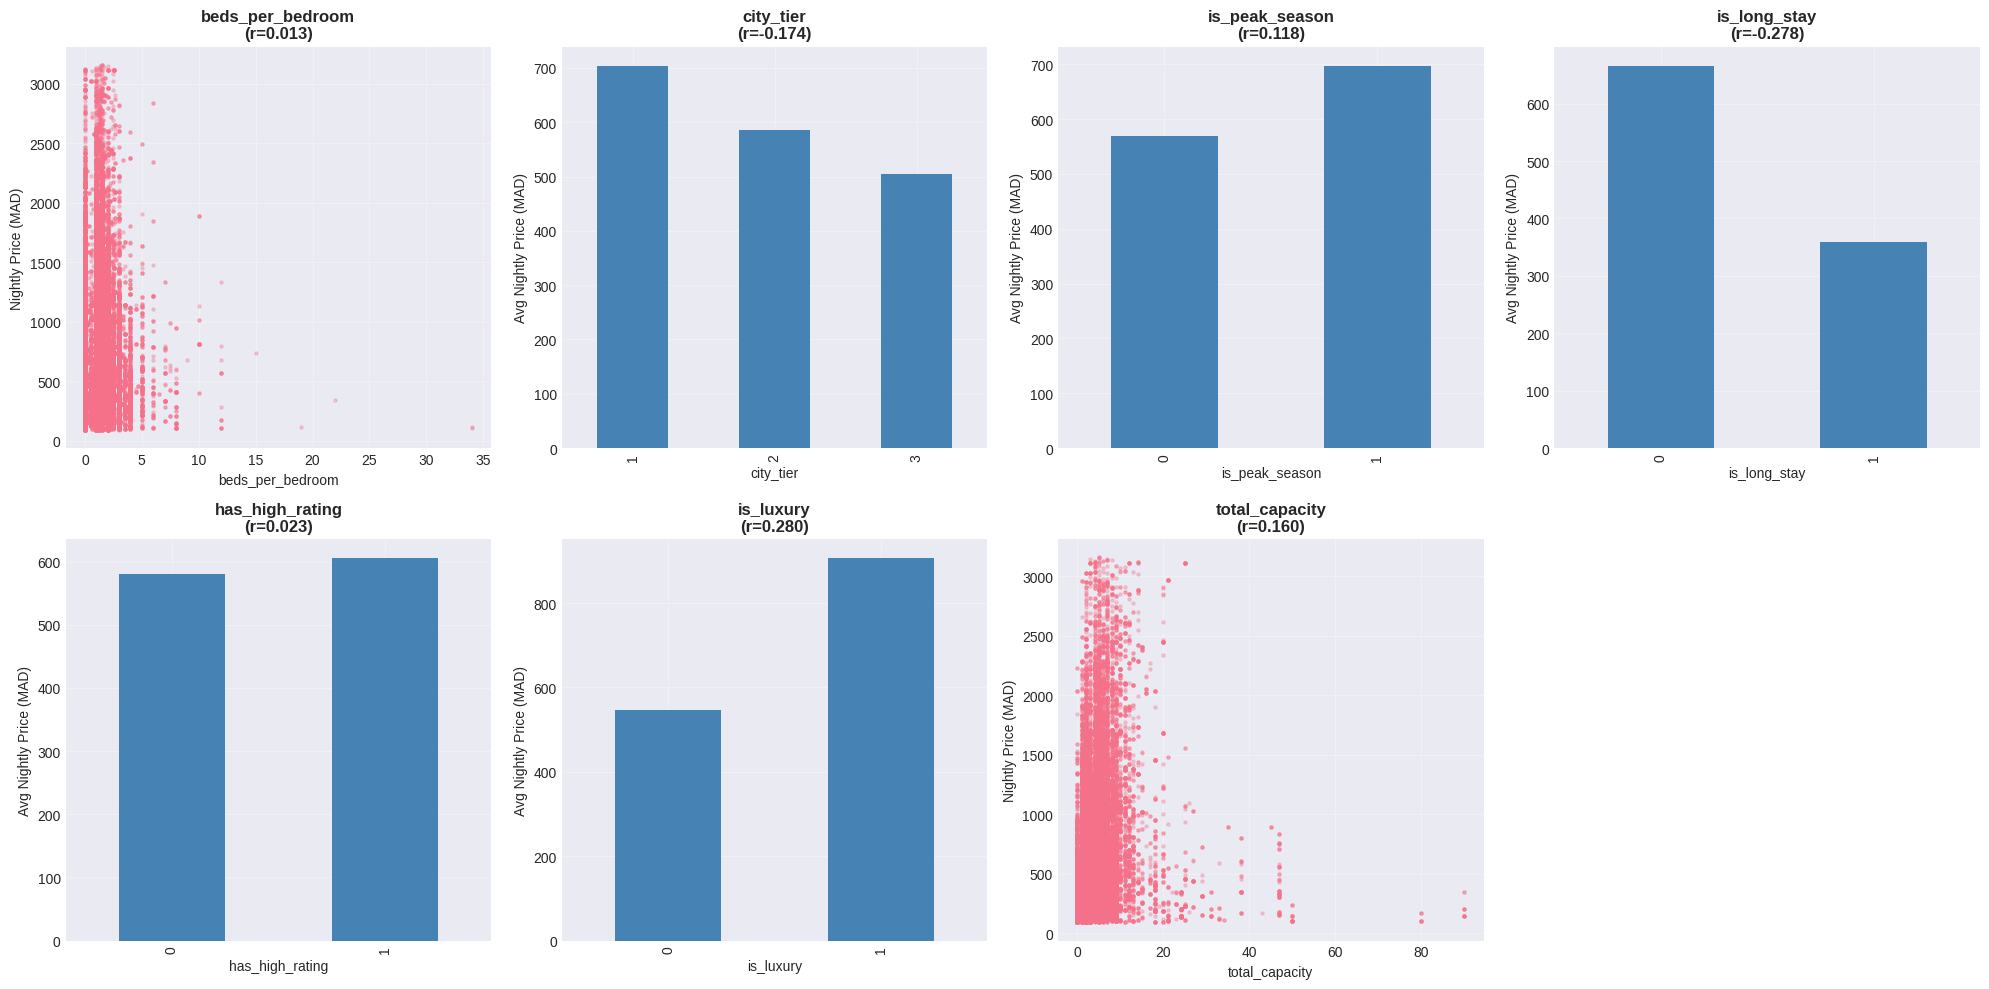

In [8]:
# Visualize engineered feature correlations
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(engineered_features):
    if df_encoded[feature].nunique() <= 10:  # Categorical-like features
        df_encoded.groupby(feature)['nightly_price'].mean().plot(kind='bar', ax=axes[i], color='steelblue')
        axes[i].set_ylabel('Avg Nightly Price (MAD)')
    else:  # Continuous features
        axes[i].scatter(df_encoded[feature], df_encoded['nightly_price'], alpha=0.3, s=5)
        axes[i].set_ylabel('Nightly Price (MAD)')
    
    axes[i].set_xlabel(feature)
    axes[i].set_title(f'{feature}\n(r={correlations[feature]:.3f})', fontweight='bold')
    axes[i].grid(alpha=0.3)

# Hide the last empty subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 6. Data Quality Checks

In [9]:
print("\n🔍 Data Quality Checks")
print("=" * 70)

# 1. Missing values
missing = df_encoded.isnull().sum()
if missing.sum() > 0:
    print("\n⚠️  Missing values found:")
    print(missing[missing > 0])
else:
    print("\n✅ No missing values")

# 2. Infinite values
inf_count = np.isinf(df_encoded.select_dtypes(include=[np.number])).sum().sum()
if inf_count > 0:
    print(f"\n⚠️  Found {inf_count} infinite values")
else:
    print("\n✅ No infinite values")

# 3. Data types
print("\n📊 Data Types:")
print(df_encoded.dtypes.value_counts())

# 4. Target variable distribution
print("\n💰 Target Variable (nightly_price) Statistics:")
print(f"   Mean:      {df_encoded['nightly_price'].mean():.2f} MAD")
print(f"   Median:    {df_encoded['nightly_price'].median():.2f} MAD")
print(f"   Std Dev:   {df_encoded['nightly_price'].std():.2f} MAD")
print(f"   Min:       {df_encoded['nightly_price'].min():.2f} MAD")
print(f"   Max:       {df_encoded['nightly_price'].max():.2f} MAD")
print(f"   Skewness:  {df_encoded['nightly_price'].skew():.2f}")


🔍 Data Quality Checks

✅ No missing values

✅ No infinite values

📊 Data Types:
bool       27
int64      12
float64     6
Name: count, dtype: int64

💰 Target Variable (nightly_price) Statistics:
   Mean:      598.79 MAD
   Median:    466.93 MAD
   Std Dev:   456.19 MAD
   Min:       91.50 MAD
   Max:       3158.33 MAD
   Skewness:  2.07


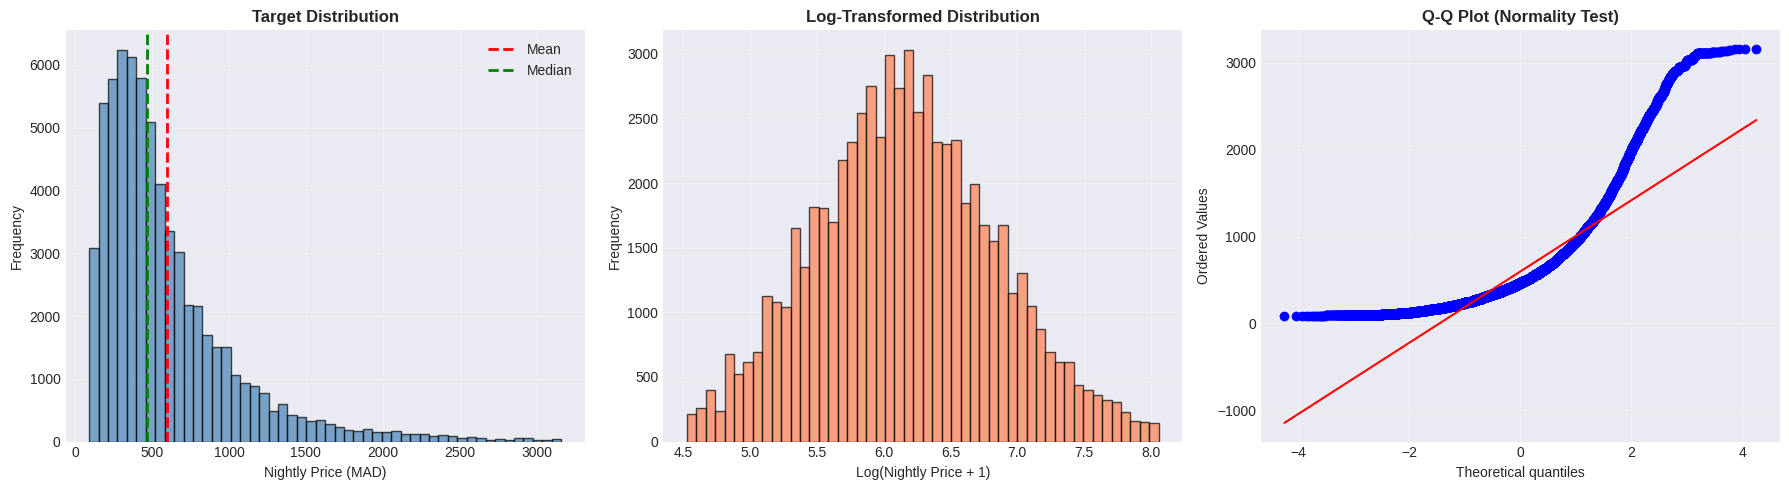

In [10]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original distribution
axes[0].hist(df_encoded['nightly_price'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(df_encoded['nightly_price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0].axvline(df_encoded['nightly_price'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0].set_xlabel('Nightly Price (MAD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Target Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Log-transformed distribution
axes[1].hist(np.log1p(df_encoded['nightly_price']), bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Log(Nightly Price + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Distribution', fontweight='bold')
axes[1].grid(alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(df_encoded['nightly_price'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot (Normality Test)', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Engineered Dataset

In [11]:
# Create output directory if it doesn't exist
OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)

# Save to CSV
df_encoded.to_csv(OUTPUT_PATH, index=False)

print("\n💾 Saved Engineered Dataset")
print("=" * 70)
print(f"   Path: {OUTPUT_PATH}")
print(f"   Rows: {len(df_encoded):,}")
print(f"   Features: {len(df_encoded.columns) - 1} (excluding target)")
print(f"   File size: {OUTPUT_PATH.stat().st_size / 1024**2:.2f} MB")

# Save feature names for reference
feature_names = [col for col in df_encoded.columns if col != 'nightly_price']
feature_info = pd.DataFrame({
    'feature_name': feature_names,
    'dtype': [str(df_encoded[col].dtype) for col in feature_names]
})

feature_info_path = OUTPUT_PATH.parent / 'feature_names.csv'
feature_info.to_csv(feature_info_path, index=False)
print(f"\n   Feature names saved to: {feature_info_path}")


💾 Saved Engineered Dataset
   Path: /home/medgm/vsc/dApp-Ai/data/used_or_will_be_used/morocco_listings_engineered.csv
   Rows: 65,988
   Features: 44 (excluding target)
   File size: 14.17 MB

   Feature names saved to: /home/medgm/vsc/dApp-Ai/data/used_or_will_be_used/feature_names.csv


## 8. Feature Engineering Summary

In [12]:
print("\n" + "=" * 70)
print("✅ FEATURE ENGINEERING COMPLETE")
print("=" * 70)

print("\n📊 TRANSFORMATION SUMMARY:")
print(f"   Original dataset:    {len(df_raw):,} rows × {len(df_raw.columns)} columns")
print(f"   Engineered dataset:  {len(df_encoded):,} rows × {len(df_encoded.columns)} columns")
print(f"   Features removed:    {len(leakage_features)}")
print(f"   Features created:    {len(engineered_features)}")
print(f"   Dummy variables:     {len(boolean_features)}")
print(f"   Final feature count: {len(df_encoded.columns) - 1} (excluding target)")

print("\n🎯 KEY FEATURES FOR MODELING:")
print("\n1. NUMERIC FEATURES (Base):")
base_numeric = ['stay_length_nights', 'bedroom_count', 'bed_count', 'discount_rate', 
                'rating_value', 'rating_count', 'badge_count', 'image_count', 
                'latitude', 'longitude', 'is_superhost']
for feat in base_numeric:
    if feat in df_encoded.columns:
        print(f"   ✓ {feat}")

print("\n2. ENGINEERED FEATURES:")
for feat in engineered_features:
    corr = correlations.get(feat, 0)
    print(f"   ✓ {feat:25s} (r={corr:6.3f})")

print("\n3. CATEGORICAL FEATURES (One-hot encoded):")
print(f"   ✓ City ({len([c for c in boolean_features if c.startswith('city_')])} dummies)")
print(f"   ✓ Season ({len([c for c in boolean_features if c.startswith('season_')])} dummies)")
print(f"   ✓ Room Type ({len([c for c in boolean_features if c.startswith('room_type_')])} dummies)")
print(f"   ✓ Property Type ({len([c for c in boolean_features if c.startswith('property_type_')])} dummies)")
print(f"   ✓ Size Category ({len([c for c in boolean_features if c.startswith('size_category_')])} dummies)")

print("\n🚀 NEXT STEPS:")
print("   1. Train-test split (80-20 or cross-validation)")
print("   2. Feature scaling (StandardScaler for tree-based models optional)")
print("   3. Model training (Linear Regression, Random Forest, XGBoost)")
print("   4. Hyperparameter tuning")
print("   5. Model evaluation (MAE, RMSE, R²)")

print("\n" + "=" * 70)


✅ FEATURE ENGINEERING COMPLETE

📊 TRANSFORMATION SUMMARY:
   Original dataset:    65,988 rows × 26 columns
   Engineered dataset:  65,988 rows × 45 columns
   Features removed:    10
   Features created:    7
   Dummy variables:     27
   Final feature count: 44 (excluding target)

🎯 KEY FEATURES FOR MODELING:

1. NUMERIC FEATURES (Base):
   ✓ stay_length_nights
   ✓ bedroom_count
   ✓ bed_count
   ✓ discount_rate
   ✓ rating_value
   ✓ rating_count
   ✓ badge_count
   ✓ image_count
   ✓ latitude
   ✓ longitude
   ✓ is_superhost

2. ENGINEERED FEATURES:
   ✓ beds_per_bedroom          (r= 0.013)
   ✓ city_tier                 (r=-0.174)
   ✓ is_peak_season            (r= 0.118)
   ✓ is_long_stay              (r=-0.278)
   ✓ has_high_rating           (r= 0.023)
   ✓ is_luxury                 (r= 0.280)
   ✓ total_capacity            (r= 0.160)

3. CATEGORICAL FEATURES (One-hot encoded):
   ✓ City (13 dummies)
   ✓ Season (3 dummies)
   ✓ Room Type (1 dummies)
   ✓ Property Type (7 dummi